# DoWhy example on the Lalonde dataset

Thanks to [@mizuy](https://github.com/mizuy) for providing this example. Here we use the Lalonde dataset and apply IPW estimator to it. 

In [1]:
import os, sys
sys.path.append(os.path.abspath("../../../"))

import dowhy
from dowhy import CausalModel
from rpy2.robjects import r as R
%load_ext rpy2.ipython

#%R install.packages("Matching")
%R library(Matching)


R[write to console]: Loading required package: MASS

R[write to console]: ## 
##  Matching (Version 4.9-7, Build Date: 2020-02-05)
##  See http://sekhon.berkeley.edu/matching for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statistical Software, 42(7): 1-52. 
##




array(['Matching', 'MASS', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], dtype='<U9')

## 1. Load the data

In [2]:
%R data(lalonde)
%R -o lalonde
lalonde = lalonde.astype({'treat':'bool'}, copy=False)

## Run DoWhy analysis: model, identify, estimate

In [3]:
model=CausalModel(
        data = lalonde,
        treatment='treat',
        outcome='re78',
        common_causes='nodegr+black+hisp+age+educ+married'.split('+'))
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting",
        target_units="ate",                         
        method_params={"weighting_scheme":"ips_weight"})
#print(estimate)
print("Causal Estimate is " + str(estimate.value))

import statsmodels.formula.api as smf
reg=smf.wls('re78~1+treat', data=lalonde, weights=lalonde.ips_stabilized_weight)
res=reg.fit()
res.summary()

/home/amit/py-envs/env3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Causal Estimate is 1639.8075601428254


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.015
Model:                            WLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     6.743
Date:                Sun, 06 Jun 2021   Prob (F-statistic):            0.00973
Time:                        19:11:54   Log-Likelihood:                -4544.7
No. Observations:                 445   AIC:                             9093.
Df Residuals:                     443   BIC:                             9102.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4555.0759    406.704     11.200      0.000    3755.767    5354.385
treat[T.True]  1639.8076    631.496      2.597      0.010     398.708    2880.907
==============================================================================
Omnibus:                      303.262   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4770.581
Skew:                           2.709   Prob(JB):                         0.00
Kurtosis:                      18.097   Cond. No.                         2.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Interpret the estimate
The plot below shows how the distribution of a confounder, "married" changes from the original data to the weighted data. In both datasets, we compare the distribution of "married" across treated and untreated units.

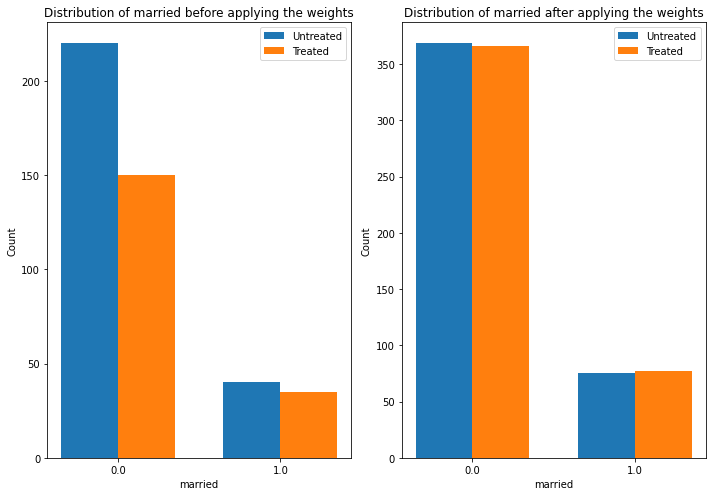

In [4]:
estimate.interpret(method_name="confounder_distribution_interpreter",var_type='discrete',
                   var_name='married', fig_size = (10, 7), font_size = 12)

## Sanity check: compare to manual IPW estimate

In [5]:
df = model._data
ps = df['ps']
y = df['re78']
z = df['treat']

ey1 = z*y/ps / sum(z/ps)
ey0 = (1-z)*y/(1-ps) / sum((1-z)/(1-ps))
ate = ey1.sum()-ey0.sum()
print("Causal Estimate is " + str(ate))

# correct -> Causal Estimate is 1634.9868359746906

Causal Estimate is 1639.8075601428245
